In [1]:
import cv2
import numpy as np 
import matplotlib.pyplot as plt
from scipy.signal import convolve2d
from math import log10, sqrt
from copy import deepcopy


In [2]:
def calculate_psnr(original_image, compressed_image):
    mse = np.mean((original_image - compressed_image) ** 2) 
    if mse == 0: 
        return float('inf')
    max_pixel = 255.0  
    psnr = 20 * log10(max_pixel / sqrt(mse))  
    return psnr

## Q1_A

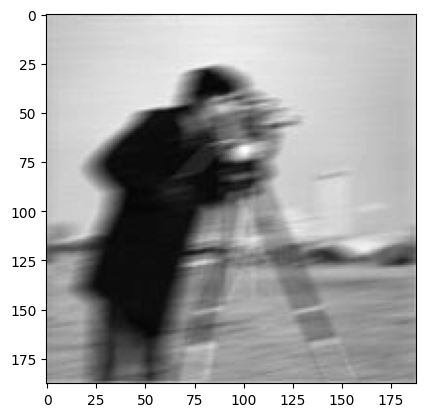

In [3]:
img1_1= cv2.imread("Q1\\1.1.jpg")
img1_1 = cv2.cvtColor(img1_1, cv2.COLOR_BGR2GRAY)
plt.imshow(img1_1,cmap="gray")

In [4]:
img1_1.shape

(188, 188)

In [5]:
img1_1 = img1_1/255

As it is being shown this image is motion blurred thus we need to use approaches like blind deconvolution bet we do not have Point Spread Function .Thus I've found that there is an iterative algorithm called richardson-lucy algorithm to find both latent image and PSF.

In [6]:
def r_l_deconvolution(blurred_img, est_img, est_psf):
    inv_psf = est_psf[::-1, ::-1]
    cnv_img = convolve2d(est_img, est_psf, 'same')
    dv_img = (blurred_img / cnv_img)
    return est_img*convolve2d(dv_img, inv_psf, 'same')

def normalize_kernel(kernel):
    return kernel / np.sum(kernel)

def scale(img):
    return (img - img.min()) / (img.max() -img.min())
    
def r_l_psf_deconvolution(blurred_img, est_img, est_psf):
    inv_est_img = est_img[::-1, ::-1]
    cnv_img = convolve2d(est_img, est_psf, 'same')
    dv_img = (blurred_img / cnv_img)
    delta = convolve2d(dv_img, inv_est_img, 'same')
    f_psf = est_psf*delta
    return normalize_kernel(f_psf) 

def blind_deconvolution_R_L(blurred_img, est_time):
    est_img = np.ones_like(blurred_img)/2 
    est_img = est_img.astype(np.float64)
    est_psf = np.ones_like(blurred_img)/np.ones_like(blurred_img).sum()
    est_psf = est_psf.astype(np.float64)
    # first we can do this deconvolution n times 
    for _ in range(est_time):
        # in each iteration estimated deconvolved img must be captured first 
        est_img = r_l_deconvolution(blurred_img, est_img, est_psf)
        # then estimated psf of next iteration must be calculated 
        est_psf = r_l_psf_deconvolution(blurred_img, est_img, est_psf)

    return scale(est_img)

In [7]:
def richardson_lucy(image, psf, num_iter):
    image = image.astype(np.float64)
    psf = psf.astype(np.float64)
    psf_mirror = psf[::-1, ::-1]
    estimate = np.ones_like(image)/2
    for _ in range(num_iter):
        relative_blur = image / convolve2d(estimate, psf, 'same')
        estimate *= convolve2d(relative_blur, psf_mirror, 'same')
    return estimate

def normalize_kernel(kernel):
    return kernel / np.sum(kernel)

def blind_deconvolution(image, psf_shape, num_iter, num_psf_iter):
    psf = np.ones(psf_shape) / np.prod(psf_shape)
    psf = psf.astype(np.float64)
    
    for _ in range(num_psf_iter):
        deconvolved_image = richardson_lucy(image, psf, num_iter)
        psf = richardson_lucy(image, deconvolved_image, num_iter)
        psf = normalize_kernel(psf)
    
    return deconvolved_image, psf

In [8]:
org_img, psf = blind_deconvolution(img1_1, (5,5), 15, 2)

In [9]:
org_img = (org_img - org_img.min())/(org_img.max() - org_img.min())

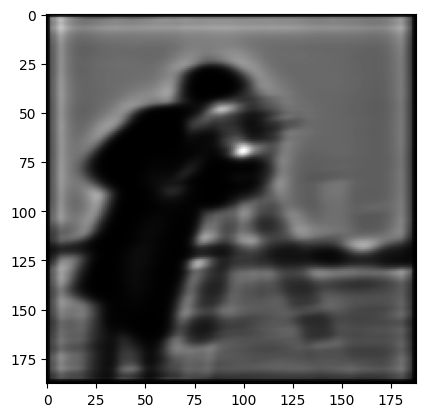

In [10]:
plt.imshow(org_img,cmap="gray")

## Q1_B

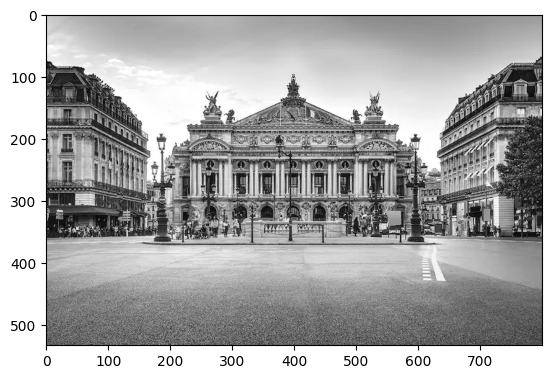

In [11]:
img1_2= cv2.imread("Q1\\1.2.jpg")
img1_2 = cv2.cvtColor(img1_2, cv2.COLOR_BGR2GRAY)
plt.imshow(img1_2,cmap="gray")

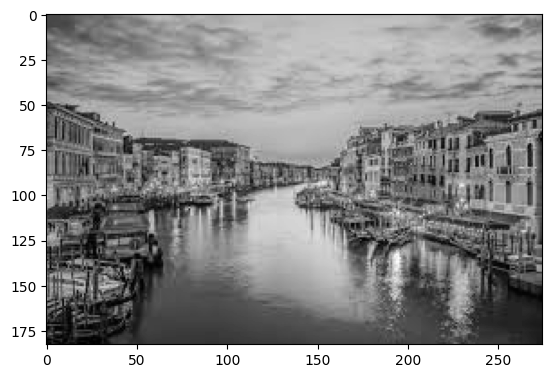

In [12]:
img1_3= cv2.imread("Q1\\1.3.jpg")
img1_3 = cv2.cvtColor(img1_3, cv2.COLOR_BGR2GRAY)
plt.imshow(img1_3,cmap="gray")

In [13]:
img1_2_edges = cv2.Canny(img1_2, 250, 254)
img1_3_edges = cv2.Canny(img1_3, 253, 254)

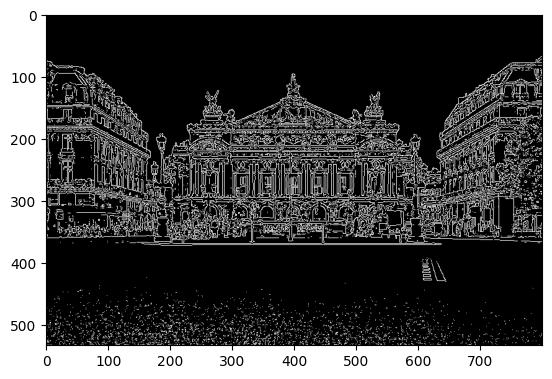

In [14]:
plt.imshow(img1_2_edges,cmap="gray")

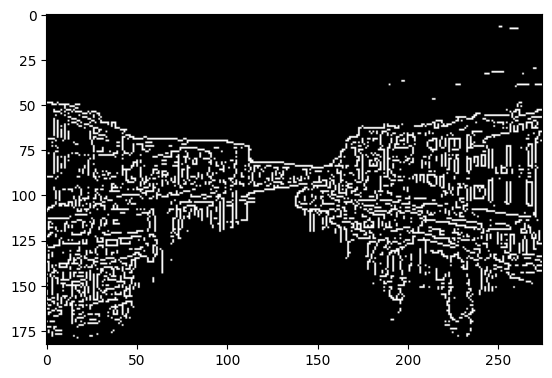

In [15]:
plt.imshow(img1_3_edges,cmap="gray")

## Q1_C

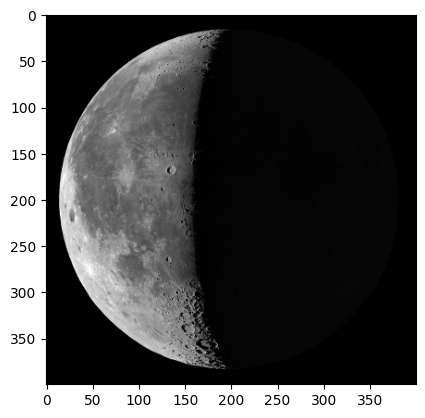

In [16]:
img1_4= cv2.imread("Q1\\1.4.jpg")
img1_4 = cv2.cvtColor(img1_4, cv2.COLOR_BGR2GRAY)
plt.imshow(img1_4,cmap="gray")

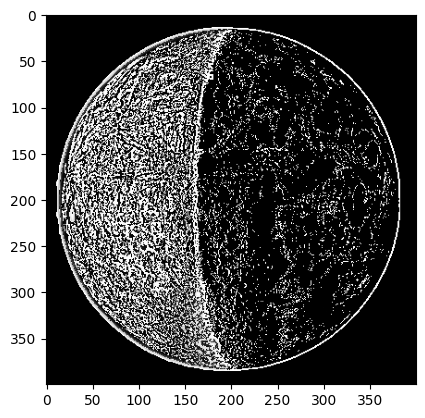

In [17]:
img1_4_sharpened = img1_4 - cv2.GaussianBlur(img1_4, (5, 5), 3)
plt.imshow(img1_4_sharpened,cmap="gray")

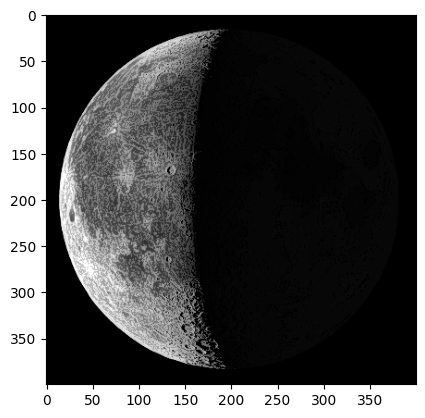

In [18]:
highboost_1_4 = cv2.addWeighted(img1_4, 1.11, img1_4_sharpened, -0.15, 0)
plt.imshow(highboost_1_4,cmap="gray")

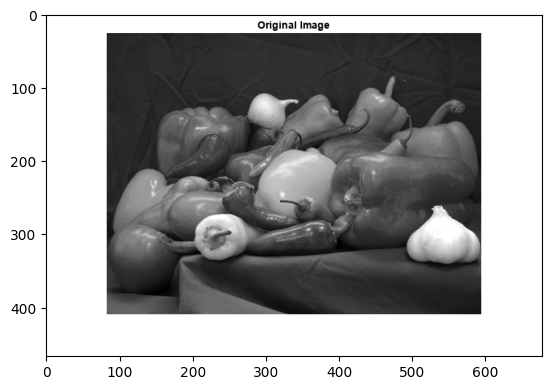

In [19]:
img1_5 = cv2.imread("Q1\\1.5.jpg")
img1_5 = cv2.cvtColor(img1_5, cv2.COLOR_BGR2GRAY)
plt.imshow(img1_5,cmap="gray")

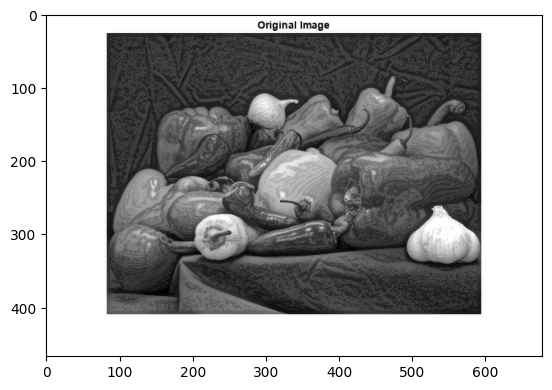

In [20]:
img1_5_sharpened = img1_5 - cv2.GaussianBlur(img1_5, (11, 11), 10)
highboost_1_5 = 1.1*img1_5 + img1_5_sharpened*-0.1
plt.imshow(highboost_1_5,cmap="gray")

## Q1_D

Im gonna use precentiling the gradient magnitude of the image thus by percentiling the approximated magnitude in the image itself we will be able to find the right percentile for example in this case that I used in the next question I used the 93 and 98 precentile to use the right threshhold

In [21]:
def dynamic_canny(img, precentiles = [93, 98]):
    gradient_x = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3)
    gradient_y = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=3)

    # Calculate the magnitude and direction of the gradients
    gradient_magnitude = np.abs(gradient_x) + np.abs(gradient_y) 

    # Calculate the quantiles of the gradient magnitude
    low_threshold, high_threshold = np.percentile(gradient_magnitude, precentiles)
    print(f" Quantiles are : {low_threshold, low_threshold}")
    return cv2.Canny(img, low_threshold, high_threshold)

In [22]:
img1_2.shape

(533, 800)

 Quantiles are : (446.0, 446.0)


Text(0.5, 1.0, 'Edges')

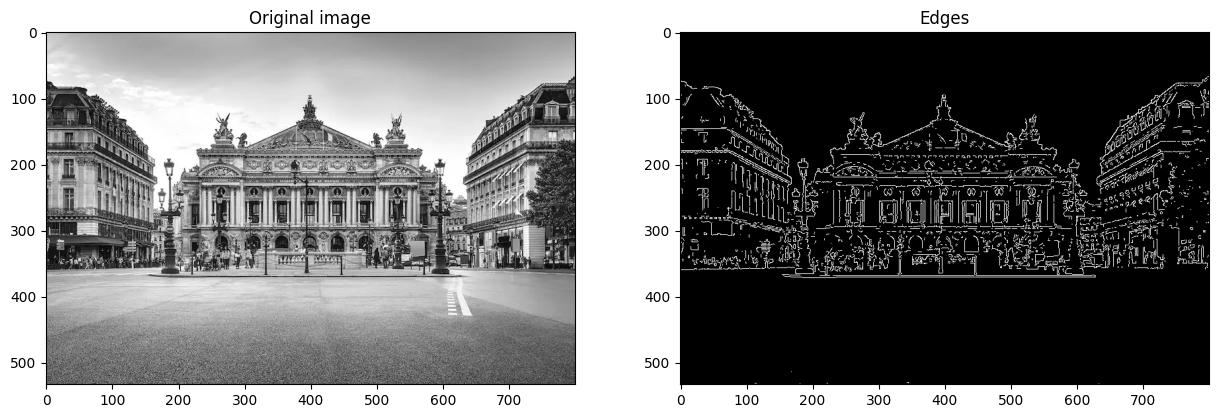

In [23]:
dynamic_edges = dynamic_canny(img1_2, [92,96])
fig , ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].imshow(img1_2,cmap="gray")
ax[0].set_title("Original image")
ax[1].imshow(dynamic_edges,cmap="gray")
ax[1].set_title("Edges")


## Q2

In [24]:
q2_imgs_list = []
for i in range(1,7):
    img = cv2.imread(f"Q2\\input{i}.jpg")
    rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    q2_imgs_list.append(rgb_img)

In [25]:
def mask_POV(img):
    mask = np.zeros_like(img)   
    ignore_mask_color = 255
    
    # Define a four sided polygon to mask
    imshape = img.shape
    vertices = np.array([
        [
            (0,imshape[0]), # bottom left
            (imshape[1] * 0.30, imshape[0] * 0.6),  # top left 
            (imshape[1] * 0.70, imshape[0] * 0.6), # top right
            (imshape[1],imshape[0]) # bottom right
        ]
    ], dtype=np.int32)
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    # to define where ever the edges are located in the predefined mask as a desired edge
    return mask
    
def dynamic_canny(img, precentiles = [93, 98]):
    gradient_x = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3)
    gradient_y = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=3)

    # Calculate the magnitude and direction of the gradients
    gradient_magnitude = np.abs(gradient_x) + np.abs(gradient_y) 

    # Calculate the quantiles of the gradient magnitude
    low_threshold, high_threshold = np.percentile(gradient_magnitude, precentiles)
    return cv2.Canny(img, low_threshold, high_threshold)

def detect(img, rho = 2.5, theta = np.pi/180, threshold=65):
    computed_img = deepcopy(img)
    hsv_img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    
    gray = hsv_img[:,:,2]
    
    edges = dynamic_canny(gray) 
    
    mask = mask_POV(edges)
    masked_img = cv2.bitwise_and(edges, mask) 

    lines = cv2.HoughLinesP(masked_img, rho, theta, threshold, maxLineGap=55, minLineLength=80) #   
    for line in lines :
        x1,y1, x2, y2= line[0]
        m = (y2-y1) / (x2-x1)
        if  -0.3 < m < 0.3:
            continue
        cv2.line(computed_img, (x1,y1), (x2, y2), (0,0,255), 4)
        

    return computed_img

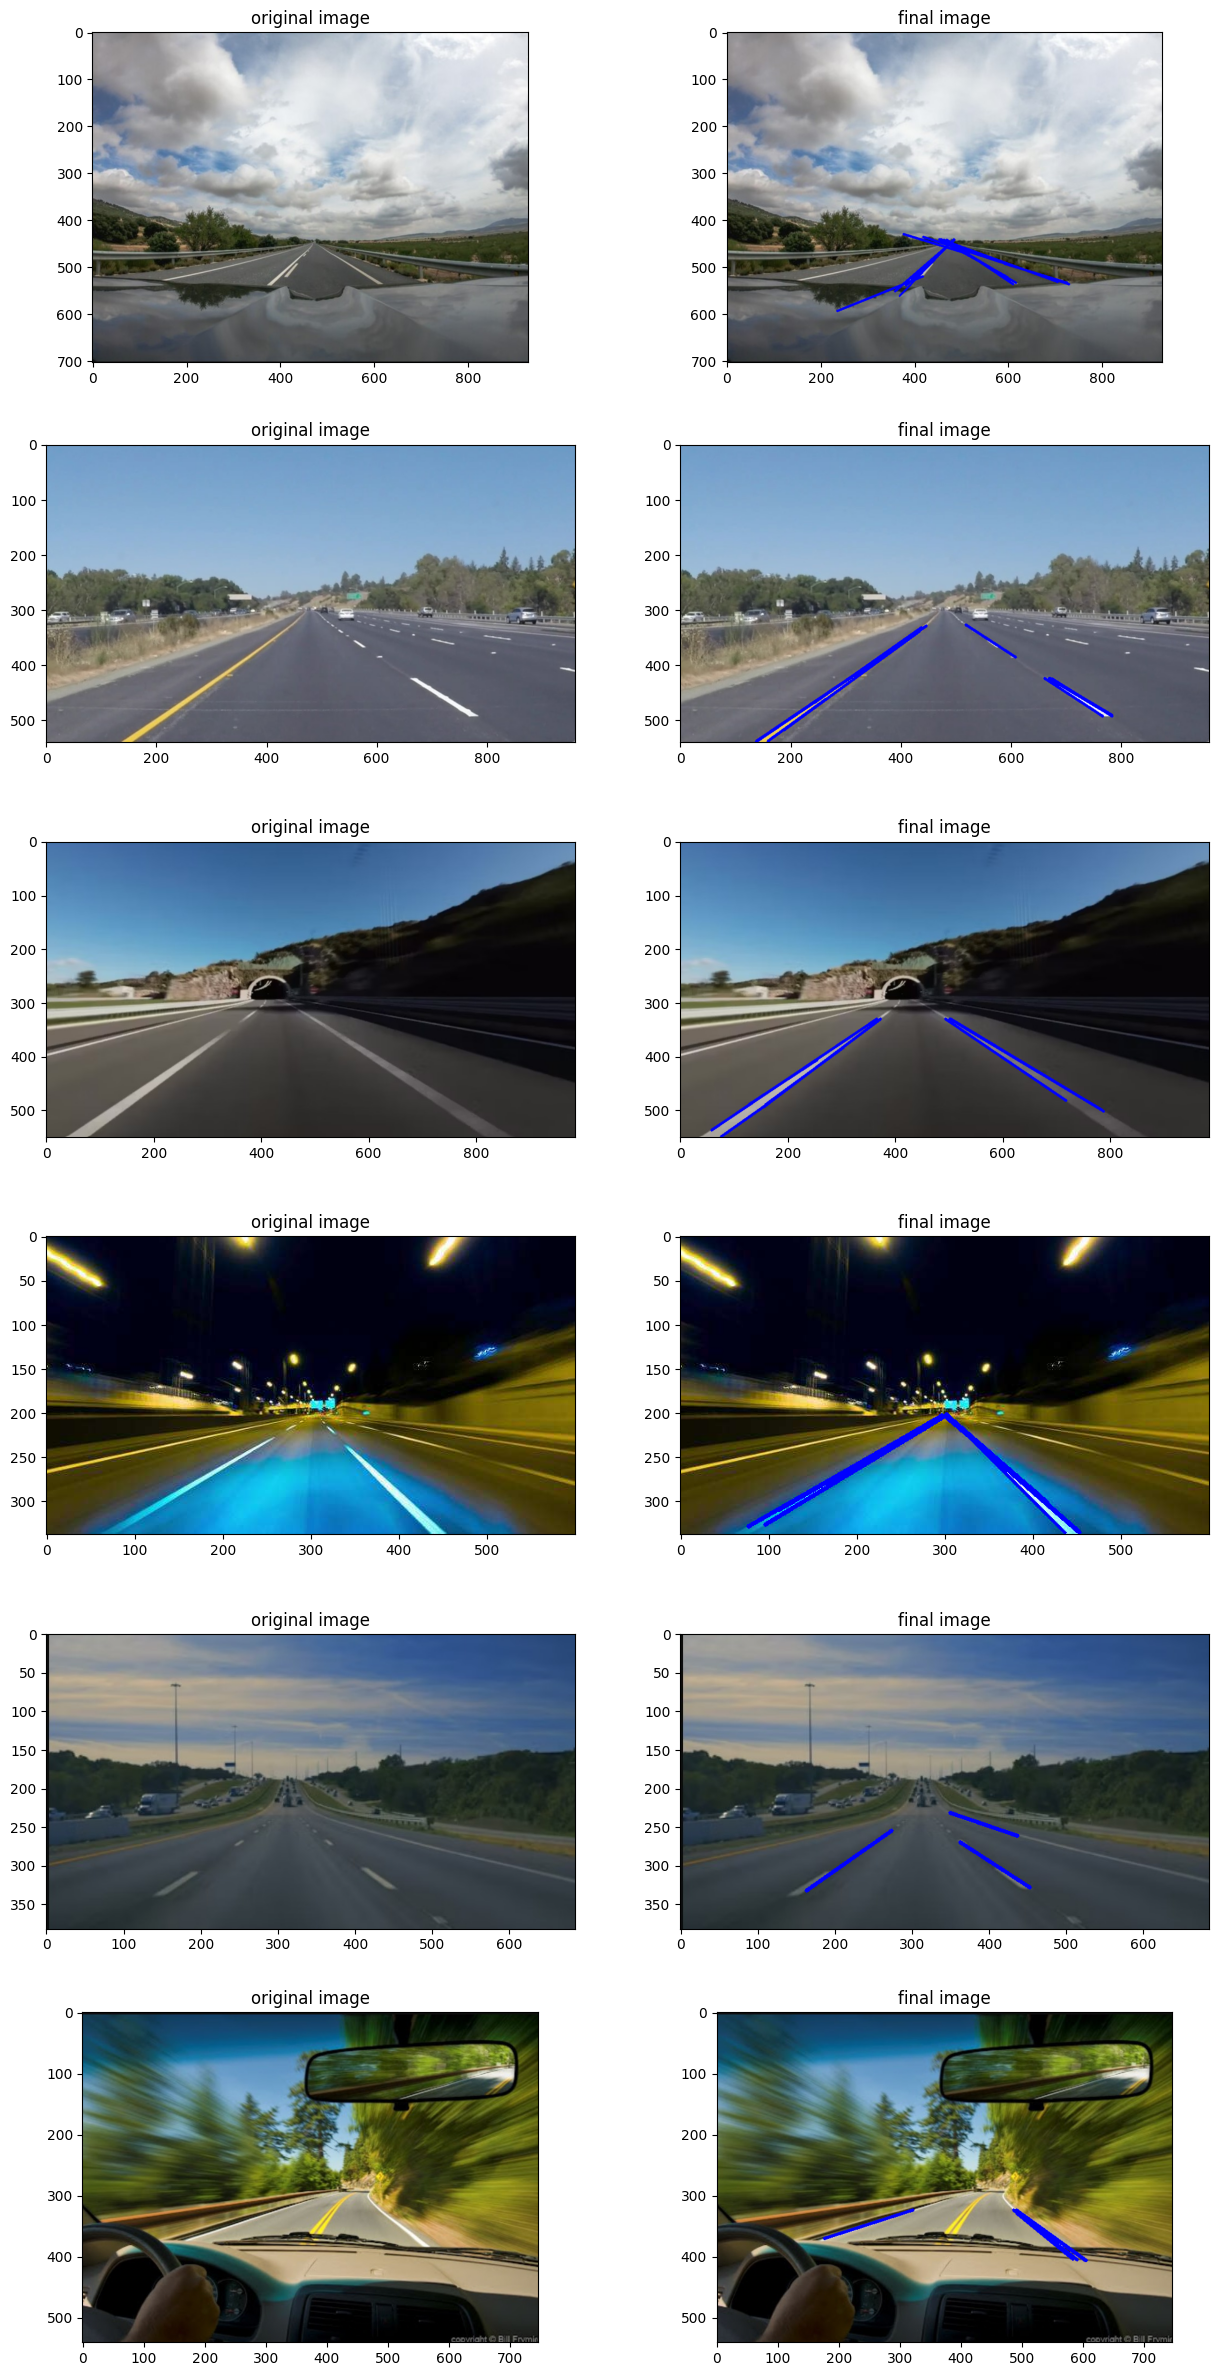

In [26]:
fig , ax = plt.subplots(len(q2_imgs_list), 2, figsize=(15, 30))
for i, img in enumerate(q2_imgs_list):
    img_ = detect(img)
    ax[i,0].imshow(img)
    ax[i,0].set_title("original image")
    ax[i,1].imshow(img_)
    ax[i,1].set_title("final image")

## Q3

In [27]:
q3_imgs_list = []
for i in range(0,9):
    img = cv2.imread(f"Q3\\3.{i}.png")
    rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    q3_imgs_list.append(rgb_img)

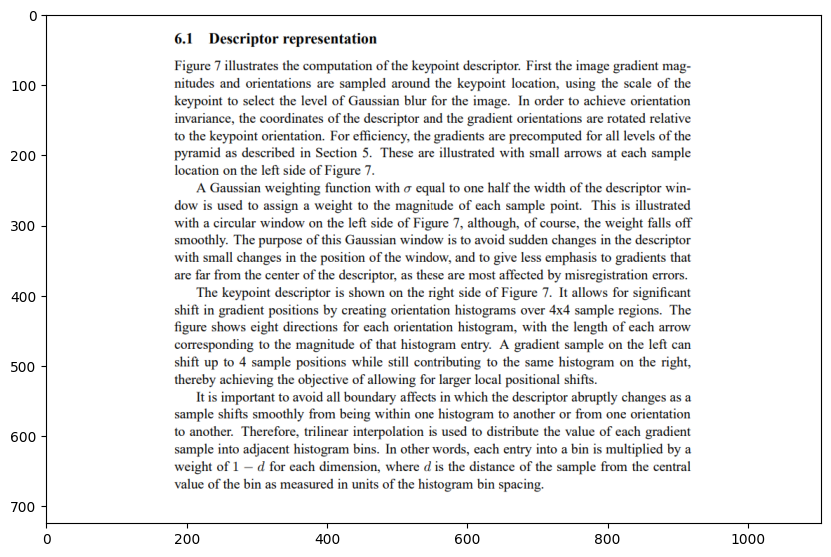

In [28]:
plt.figure(figsize=(10,10))
plt.imshow(q3_imgs_list[0])

#### HOG implementation
##### HOG is used in find_query_in_textbook by convolving the image and finding its HOG and compare it with the HOG of the query image which in our case I assumed queries are images from 3.1 up to 3.2

In [29]:
def compute_hog_descriptor(image):
    hog = cv2.HOGDescriptor()
    h, w = image.shape[:2]
    # Resize the image to a fixed size to standardize HOG computation
    resized_image = cv2.resize(image, (64, 128))
    hog_descriptor = hog.compute(resized_image)
    return hog_descriptor

def find_query_in_textbook(textbook_image, query_image):
    textbook_gray = cv2.cvtColor(textbook_image, cv2.COLOR_BGR2GRAY)
    query_gray = cv2.cvtColor(query_image, cv2.COLOR_BGR2GRAY)
    
    h_query, w_query = query_gray.shape
    query_hog_descriptor = compute_hog_descriptor(query_gray)
    
    # Sliding window parameters
    window_size = (w_query, h_query)
    step_size = 2  # Step size for the sliding window

    best_match = None
    min_distance = float('inf')
    
    for y in range(0, textbook_gray.shape[0] - window_size[1], step_size):
        for x in range(0, textbook_gray.shape[1] - window_size[0], step_size):
            window = textbook_gray[y:y + window_size[1], x:x + window_size[0]]
            window_hog_descriptor = compute_hog_descriptor(window)
            
            distance = np.linalg.norm(query_hog_descriptor - window_hog_descriptor)
            
            if distance < min_distance:
                min_distance = distance
                best_match = (x, y)
    
    threshold = 5  # Define a suitable threshold based on your needs
    if min_distance < threshold:
        top_left = best_match
        bottom_right = (top_left[0] + window_size[0], top_left[1] + window_size[1])
        return top_left, bottom_right
    else:
        return None, None


Query image not found in the textbook image.


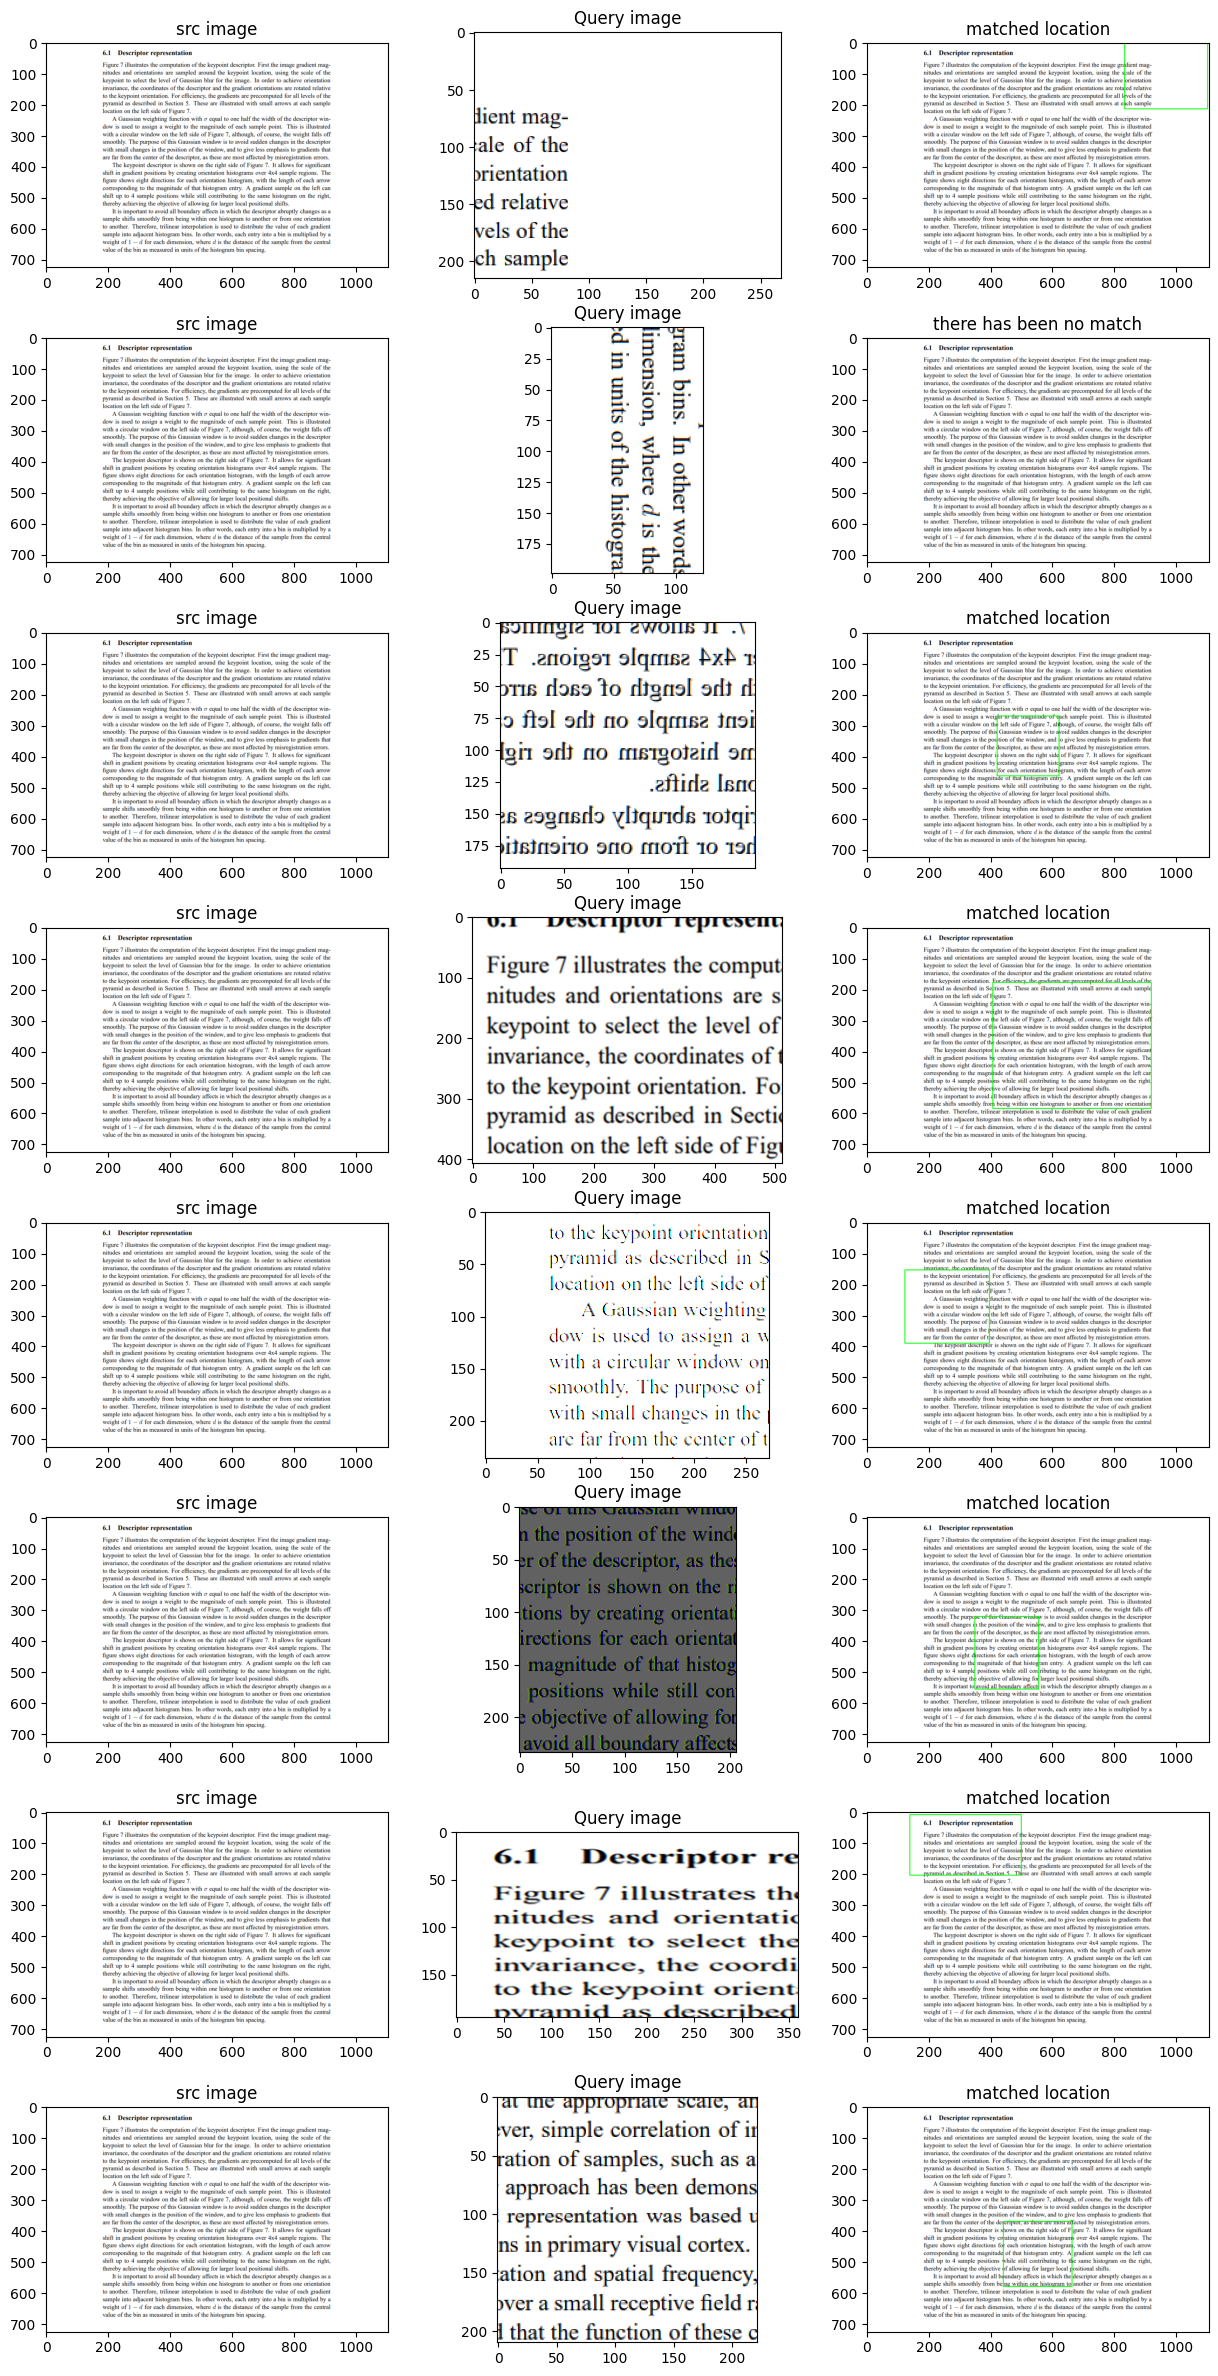

In [30]:
fig , ax = plt.subplots(len(q3_imgs_list)-1, 3, figsize=(15, 30))
for i in range(1,9):
    textbook_image = deepcopy(q3_imgs_list[0])
    query_image = q3_imgs_list[i]
    top_left, bottom_right = find_query_in_textbook(textbook_image, query_image)
    ax[i-1,0].imshow(textbook_image)
    ax[i-1,0].set_title("src image")
    ax[i-1,1].imshow(query_image)
    ax[i-1,1].set_title("Query image")

    if top_left and bottom_right:
        cv2.rectangle(textbook_image, top_left, bottom_right, (0, 255, 0), 2)
        ax[i-1,2].imshow(textbook_image)
        ax[i-1,2].set_title("matched location")
    else:
        print("Query image not found in the textbook image.")
        ax[i-1,2].imshow(textbook_image)
        ax[i-1,2].set_title("there has been no match")

HOG used to detect query image in the src image and it performed reasonably ok for such a task , but it has many cons as its shown in its performance:
This feature extractor failed to detect images that rotation transformation has been applied on theme like its performance on second image. unexpectedly it happens to detect images that more likely to streched as it is shown in 7th query image, and not to forget it is invarient to changes in intensity lik"e it is shown in 6th image.
But both of these approaches HOG and SIFT are given false match for the last image. which means as much powerfull as they are but they are still not capable of detecting rich spacial features not only pointwise features

#### SIFT implementation

In [31]:
def sift_img_matching(img1, img2):
    sift = cv2.SIFT_create()
    result = deepcopy(img1)

    img1_gray = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)
    img2_gray = cv2.cvtColor(img2, cv2.COLOR_RGB2GRAY)
    bruteForce_matching = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
    keyPoints_im1, descriptor_im1 = sift.detectAndCompute(img1_gray, None)# None is used to define there has been no predefined mask in the image
    keyPoints_im2, descriptor_im2 = sift.detectAndCompute(img2_gray, None)

    matches = bruteForce_matching.match(descriptor_im2, descriptor_im1)
    matches = sorted(matches, key=lambda x:x.distance)
    
    
    good_matches = []
    distance_threshold = 100
    # print(matches[-1].distance)
    for match in matches:
        if match.distance < distance_threshold:
            good_matches.append(match)

    if len(good_matches) > 50:
        query_pts = np.float32([keyPoints_im2[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        original_pts = np.float32([keyPoints_im1[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        M, mask = cv2.findHomography(query_pts, original_pts, cv2.RANSAC, 5.0)

        inlier_matches = [good_matches[i] for i in range(len(good_matches)) if mask[i]]

        # Apply transformation matrix to query image bounding box
        h, w = img2_gray.shape[:2]
        #                    top left, bottom left, bottom right, top right
        query_bbox = np.float32([[0, 0], [0, h], [w, h], [w, 0]]).reshape(-1, 1, 2)
        transformed_bbox = cv2.perspectiveTransform(query_bbox, M)

        # Draw the bounding box on the original image
        cv2.polylines(result, [np.int32(transformed_bbox)], True, (0, 255, 0), 2)
        match_img = cv2.drawMatches(img2, keyPoints_im2, result, keyPoints_im1, inlier_matches, None, flags=2)

        return match_img

    else:
        return None

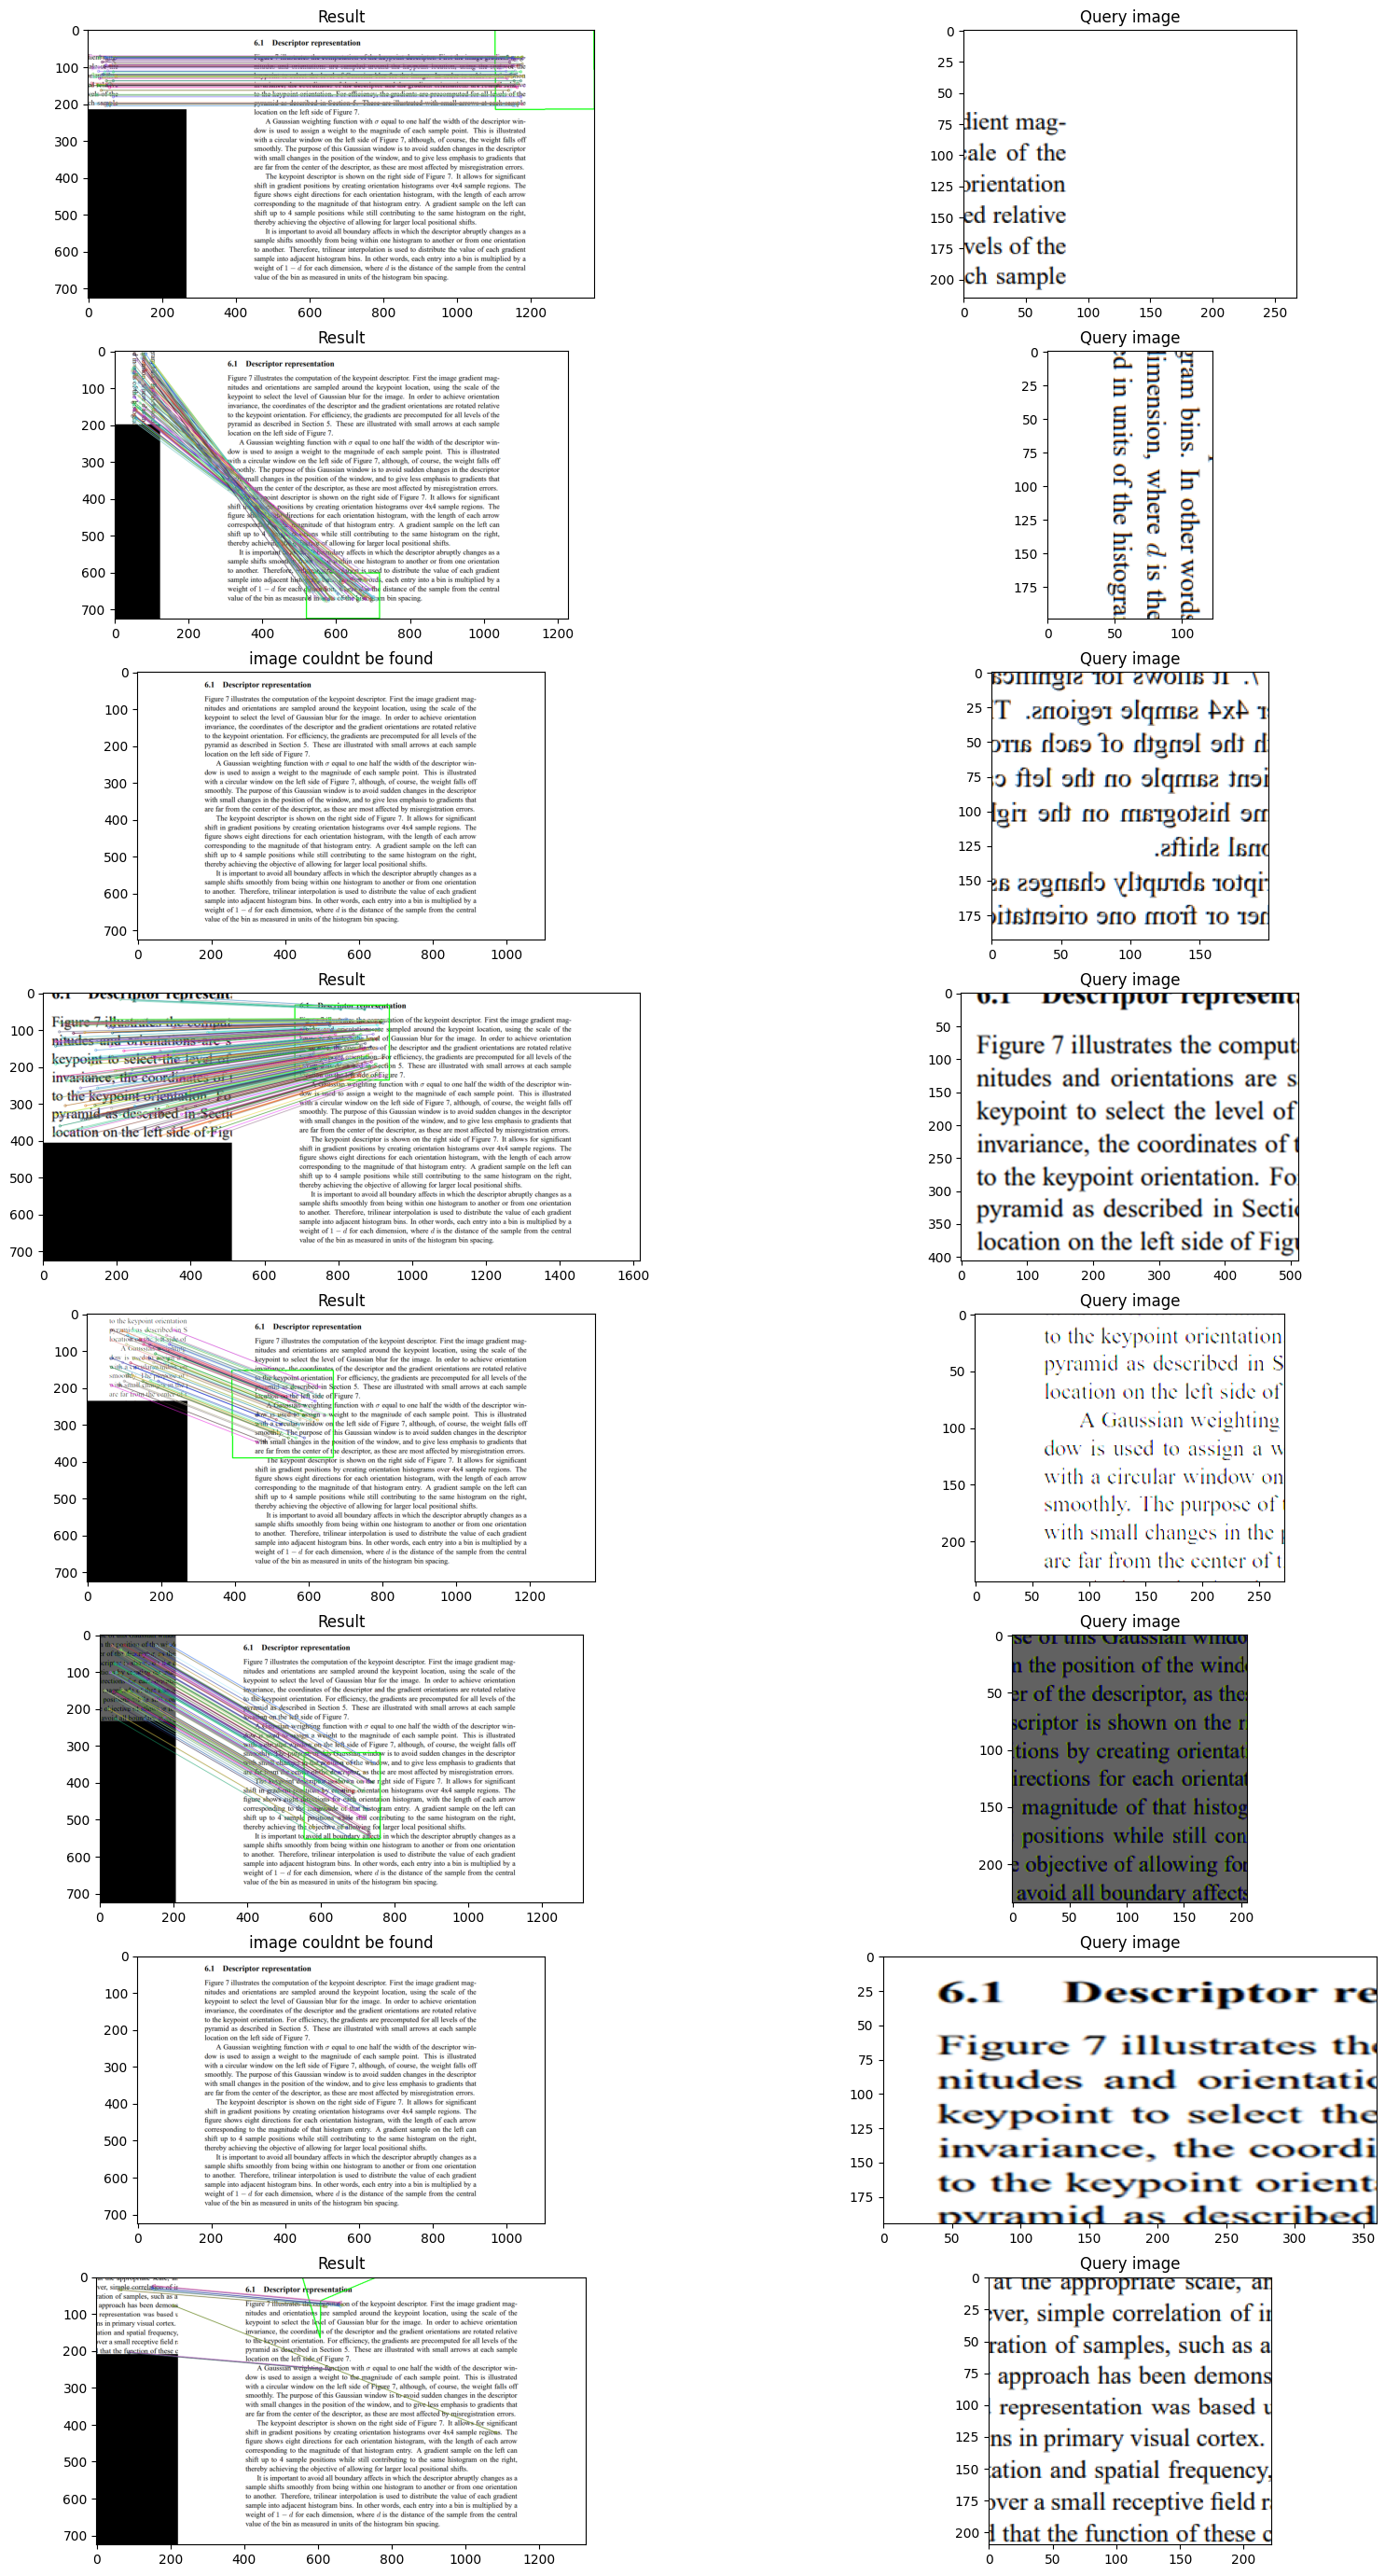

In [32]:
fig , ax = plt.subplots(len(q3_imgs_list)-1, 2, figsize=(20, 35))
for i in range(1,9):
    textbook_image = deepcopy(q3_imgs_list[0])
    query_image = q3_imgs_list[i]
    matched_res = sift_img_matching(textbook_image, query_image)
    if matched_res is not None :
        ax[i-1,0].imshow(matched_res)
        ax[i-1,0].set_title("Result")
    else : 
        ax[i-1,0].imshow(textbook_image)
        ax[i-1,0].set_title("image couldnt be found")
    ax[i-1,1].imshow(query_image)
    ax[i-1,1].set_title("Query image")
    

This last query image wasnt in the src image but it did detect it and found highly close features to it thus we can count it as a false positive 

For quick review of the result I should mention SIFT is scale invariant and as I noticed in the second image it is also rotation equivarient aswell thus it was able to detect second image but unbelivably notice that it is not capable of dealing with streched images or we can say it is not equivarient to streching as its shown in 7th image .And also its invarient to intensity changes thus it could have detected the 6th image .
Highly noticable difference between SIFT and HOG is on its scale and rotation equivariency it has.